In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
import sys
import cvxpy as cp

In [1]:
import reconstruction_alg as rec
from utils import *

# A first glimpse at reconstruction algorithms 

For this project, we implement 4 different "reconstruction algorithms". Given a test matrix $\mathbf{M}$ of size $T \times n$ and a test result $\mathbf{y}$ in $\left\{0,1 \right\}^T$, these algorithms seek to reconstruct the vector $ \mathbf{x} \in \left\{0,1\right\}^n$ that is linked to $\mathbf{y}$ and $\mathbf{M}$ through the relation 

$$ \mathbf{y} =  \mathbf{M} \mathbf{x}.$$

More precisions are given in the companion .pdf file to this project. 

Let us first introduce two small functions. The function `create_input(n,p)` creates an vector in $\left\{0,1\right\}^n$ of independant individuals which are set randomly to be either healthy (0) with probability $p$ or sick (1) with probability $1-p$.  

In [4]:
x = create_input(100,0.9)
print(x)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0]


The function `create_tests(T,n,alpha)` creates a test matrix $\mathbf{M}$ of size $T \times n$ (i.e. $T$ tests for a population of $n$ individuals)  with entries in $\left\{0,1 \right\}$ set randomly to 0 with probability alpha. 

In [123]:
m = create_tests(4,100,0.9)
print(m)
print(m@x)

[[0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
  0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
[1 1 1 1]


## The COMP algorithm

The COMP algorithm is the most basic one can think of: given a test result and a test matrix, it declares as healthy all individuals that are in negative tests, and positive all others. It is conservative in the sens that it only makes false positives, and no false negatives.
You can instanciate the algorithm with a true vector $\mathbf{x}$ and a test matrix $\mathbf{M}$ by calling `COMP(true_x,test_matrix)`. Methods and a more detailled description of the algorithm can be found by calling `help()`.

In [124]:
comp = rec.COMP(x,m)

`reconstruct()` gives the approximation of the true vector $\mathbf{x}$ computed by the algorithm. 

In [125]:
print(comp.reconstruct())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


`score()` computes the 0-1 loss.

In [126]:
print(comp.score())

0.1


The `average_score(mat_size,number,alpha)` can be used to perform a test of the COMP algorithm: for a given true vector given when instanciating, it computes the average score over `number` test matrices with `mat_size` tests, whose inputs are randomly and independantly set to 0 with probability `alpha`.  

In [24]:
print(comp.average_score(70,1000,0.9))

0.9257400000000034


Finally, the method `confusion_matrix(plot=False,absv=False)` yields the confusion matrix of the algorithm. If `plot=True`, it plots it using `seaborn`. If `absv=True`, it gives absolute values instead of percentages.  

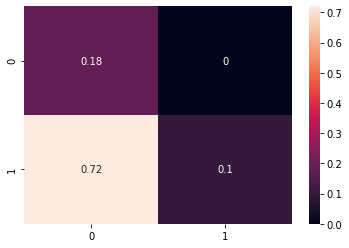

In [33]:
comp.confusion_matrix(plot=True)

## The DD algorithm

The DD algorithm works in three stages:
- It performs a COMP stage 
- It then declares positive all individuals that are in tests groups from which all other members have been declared healthy in the previous step. 
- Finally, it classifies as healthy all remaining individuals. 

This last step is motivated by the high sparsity of the vector $x$: since $x$ is sparse, there is little chance to create false negatives. Notice also that this algorithm only makes false negatives.  
Methods and instanciation are identical to the COMP algorithm.

0.9


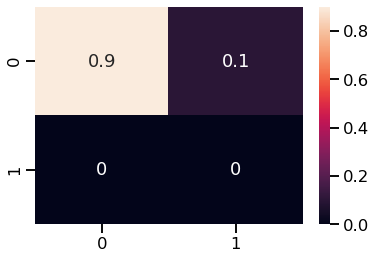

In [141]:
dd = rec.DD(x,m)
print(dd.score())
dd.confusion_matrix(plot=True)

## The SCOMP algorithm

The SCOMP algorithm works in a recursive manner:
- It first performs the two first steps of the DD algorithm, but without declaring all non identified individuals as healthy. This produces an estimated vector $\mathbf{\tilde{x}}$.
- It then iteratively checks if $ \mathbf{y}=\mathbf{M}\mathbf{\tilde{x}}$. If not, it identifies the individual which is present in the greatest number of unexplained tests (i.e. positive tests which do not include any individual that is already known to be positive) and declares her positive. 

Methods and instanciation are identical.

0.89


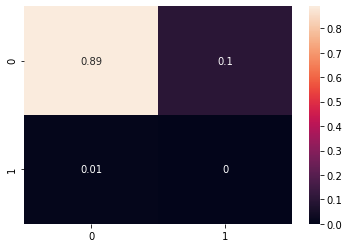

In [6]:
scomp = rec.SCOMP(x,m)
print(scomp.score())
scomp.confusion_matrix(plot=True)

## The LP relaxation algorithm

The LP relaxation algorithm computes an estimation by solving an convex optimization problem, which is a relaxed version of the non-convex combinatorial problem of group testing. The solver used here is CVXPY. Methods and instanciation are identical.

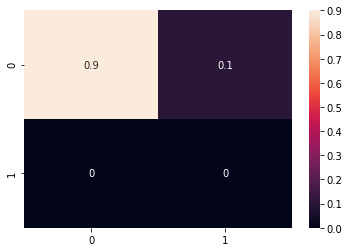

In [13]:
lp = rec.LP(x,m)
lp.score()
lp.confusion_matrix(plot=True)

## Some first comparaisons

Let us first compare the algorithms based on their average scores while varying the matrix size.  

In [120]:
#Hyperparameters 

test_sample = 10
matrix_alpha = 0.99
x_sparsness = 1/2
x_size = 500
mat_size = 100

In [121]:
import tqdm

comp_scores = np.zeros(mat_size)
dd_scores = np.zeros(mat_size)
scomp_scores = np.zeros(mat_size)
lp_scores= np.zeros(mat_size)

for grouptest in tqdm.tqdm(np.arange(test_sample)):
    
    matrix = create_tests(mat_size,x_size,matrix_alpha)
    true_x = create_input(x_size,x_sparsness)
    
    for size in np.arange(0,mat_size):
        
        test_matrix = matrix[0:size+1,:]
        comp = rec.COMP(true_x,test_matrix)
        comp_scores[size] += comp.score()
        dd = rec.DD(true_x,test_matrix)
        dd_scores[size] += dd.score()
        scomp = rec.SCOMP(true_x,test_matrix)
        scomp_scores[size] += scomp.score()
        #lp = rec.LP(true_x,test_matrix)
        
    sys.exit()
comp_scores *= 1/test_sample
scomp_scores *= 1/test_sample
dd_scores *= 1/test_sample
lp_scores *= 1/test_sample
        
        
        
        






  0%|          | 0/10 [00:00<?, ?it/s]

SystemExit: 

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


[0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498
 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498
 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498
 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498
 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.498 0.5
 0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5
 0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5
 0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5
 0.5   0.5   0.5   0.5  ]


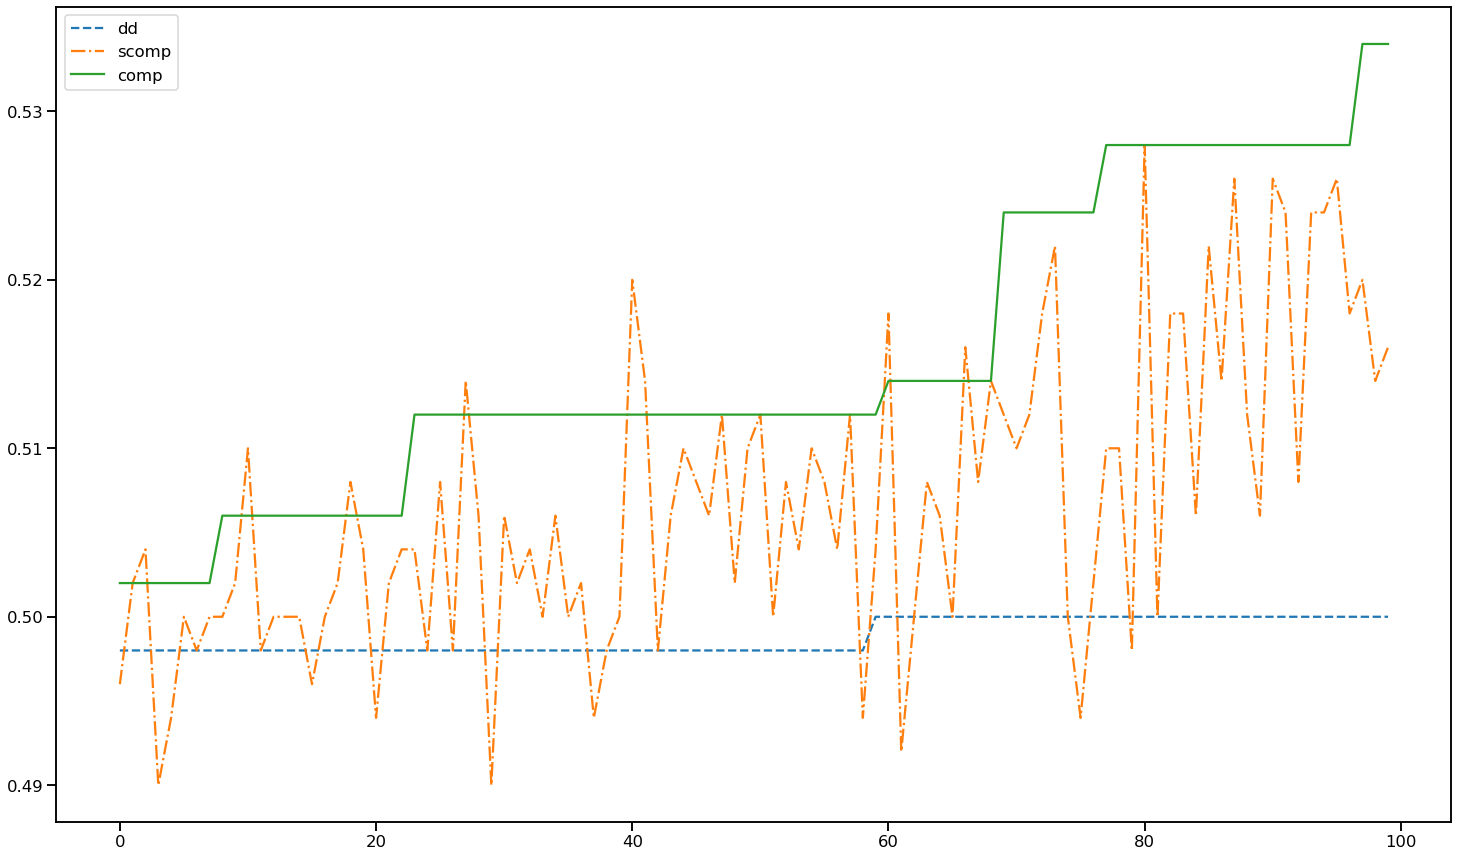

In [122]:
sns.set_context('talk')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_scores, label='dd',linestyle='--')
ax.plot(scomp_scores, label ='scomp',linestyle='-.')
ax.plot(comp_scores, label = 'comp')
ax.legend()

print(dd_scores)

plt.show()